In [1]:
import numpy as np
import scipy.optimize as opt
import scipy.signal as sig
import scipy.integrate as itg
import scipy.special as sf
import matplotlib.pyplot as plt

In [2]:
counts = np.loadtxt("4 Day Data.Spe", skiprows = 12, max_rows = 256, dtype = int)

In [3]:
background = np.loadtxt("Noise 2 Day.Spe", skiprows = 12, max_rows = 256, dtype = int)

In [4]:
bins, time = np.loadtxt("TAC.txt", skiprows = 4, unpack = True)

In [5]:
t_c = 428000 # seconds
t_b = 161433 # Pulled manually from .Spe data file
day = 24 * 3600

print(f"{t_c / day} days")
print(f"{t_b / day} days")

4.953703703703703 days
1.8684375 days


In [6]:
T = lambda b, A, c: A * (b - c)
sigma_t = 20 # ns
Pt, covt = opt.curve_fit(T, bins, time, sigma = sigma_t) # note; specifying a constant sigma doesn't seem to do anything.
m = Pt[0]

In [7]:
print(f"{Pt[0]:.2f} pm {np.sqrt(covt[0,0]):.2f}")
print(f"{Pt[1]:.2f} pm {np.sqrt(covt[1,1]):.2f}")

94.77 pm 0.57
3.87 pm 0.12


In [8]:
t_max = 20000 # TAC max range is 20 microseconds

b_min = 10
b_max = int((t_max - Pt[1]) / Pt[0])
#b_max = 214
n = b_max - b_min

In [9]:
ctrunc = counts[b_min:b_max]
ctrunc40 = counts[b_min:40]

In [10]:
print(f"Total rate: {np.sum(ctrunc) / n / t_c * day:.2f}/bin/day")

Total rate: 7.59/bin/day


In [11]:
btrunc = background[b_min:b_max]

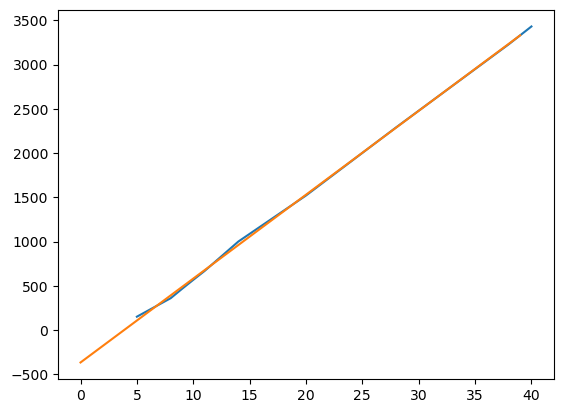

In [12]:
x = np.arange(0, 40)
plt.plot(bins, time)
plt.plot(x, T(x, *Pt))

In [13]:
print(f"{Pt[0]:.2f} ns per bin pm {np.sqrt(covt[0,0]):.2f}")

94.77 ns per bin pm 0.57


In [14]:
X = np.array(range(b_max-b_min))

In [15]:
sig_b = 2.5 # background has magnitude around 6: sigma = sqrt(6) ~ 2.5

B = lambda x, B, b: B * np.exp(-x / b)
p = [10, 300]
P_B, cov_B = opt.curve_fit(B, X, btrunc, p0 = p)

In [16]:
print(f"Background time constant: {P_B[1]:.0f} pm {np.sqrt(cov_B[1,1]):.0f} bins = {P_B[1] * m / 1000:.0f} pm {m * np.sqrt(cov_B[1,1]) / 1000:.0f}us")

Background time constant: 1876 pm 1772 bins = 178 pm 168us


In [17]:
# analytic integration of the background
# (assuming it is a flat distribution transformed by nonlinearity)
cum = P_B[1] * (B(0, *P_B) - B(n, *P_B))
print(cum)
A = cum / n
print(A)
convert = lambda x: P_B[1] * (P_B[0] - B(x, *P_B)) / A
yconvert = lambda x, y: y * (A / B(x, *P_B))
X_prime = convert(X)
c_prime = yconvert(X, ctrunc)
b_prime = yconvert(X, btrunc)

1362.6253679331528
6.813126839665764


In [18]:
# numerical integration for funsies
itg.quad(B, 0, n, tuple(P_B))

(1362.625367933154, 1.512818057417713e-11)

In [19]:
print(f"Background rate: {A / t_b * day:.2f}/bin/day")

Background rate: 3.65/bin/day


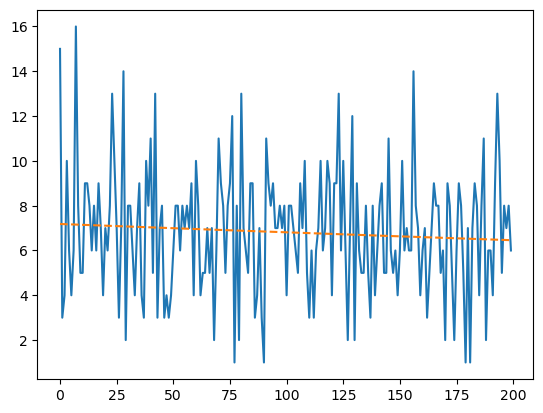

In [20]:
plt.plot(btrunc)
plt.plot(B(X, *P_B), '--')

In [21]:
F = lambda x, A, a, B, b: A * np.exp(-x / a) + B * np.exp(-x / b)
p = [250, 30, 50, 100]
P, cov = opt.curve_fit(F, X, ctrunc, p0 = p)

In [22]:
# Poisson Distribution (wikipedia).
# With a rate of lambda per time period, the variance is lambda.
# Therefore, the standard deviation is the square root of the rate.
# F1 results will be used to estimate the rate, then we will refit with a proper sigma array.

sigma = np.sqrt(F(X, *P))
sig40 = sigma[0:len(ctrunc40)]

In [23]:
p = [250, 30, 50, 100]
Ps, covs = opt.curve_fit(F, X, ctrunc, p0 = p, sigma = sigma)

In [24]:
X40 = np.array(range(40 - b_min))

In [25]:
F2 = lambda x, A, a, C: A * np.exp(-x / a) + C
p = [250, 30, 15]
P2, cov2 = opt.curve_fit(F2, X, ctrunc, p0 = p)
P2s, cov2s = opt.curve_fit(F2, X, ctrunc, p0 = p, sigma = sigma)
P2as, cov2as = opt.curve_fit(F2, X40, ctrunc40, p0 = p, sigma = sig40)
P2_prime, cov2_prime = opt.curve_fit(F2, X_prime, c_prime, p0 = p, sigma = sigma) #sigma will still be mostly accurate

In [26]:
F3 = lambda x, A, a, B: A * np.exp(-x / a) + B * np.exp(-x / P_B[1])
p = [250, 30, 50]
P3, cov3 = opt.curve_fit(F3, X, ctrunc, p0 = p)
P3s, cov3s = opt.curve_fit(F3, X, ctrunc, p0 = p, sigma = sigma)

In [27]:
F3a = lambda x, A, a: A * np.exp(-x / a) + P3[2] * np.exp(-x / P_B[1])
p = [250, 30]
P3a, cov3a = opt.curve_fit(F3a, X40, ctrunc40, p0 = p)
P3as, cov3as = opt.curve_fit(F3a, X40, ctrunc40, p0 = p, sigma = sig40)

In [28]:
# Model 1
dof = b_max - b_min - 4
chisq = np.sum(((F(X, *P) - ctrunc) / sigma) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

1.1045493599841982


0.1504829115076304

In [29]:
# Model 2
dof = b_max - b_min - 4
chisq = np.sum(((F2(X, *P2) - ctrunc) / sigma) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

1.097084591617115


0.16725925334399847

In [30]:
# Model 3
dof = b_max - b_min - 4
chisq = np.sum(((F3(X, *P3) - ctrunc) / sigma) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

1.0940912135398124


0.17433536475763142

In [31]:
# Model 1S
dof = b_max - b_min - 4
chisq = np.sum(((F(X, *Ps) - ctrunc) / sigma) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

1.0853991203557827


0.1960206842853215

In [32]:
# Model 2S
dof = b_max - b_min - 3
chisq = np.sum(((F2(X, *P2s) - ctrunc) / sigma) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

1.080242371275003


0.2091420840036846

In [33]:
# Model 3S
dof = b_max - b_min - 3
chisq = np.sum(((F3(X, *P3s) - ctrunc) / sigma) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

1.0799175475744127


0.21002353554310577

In [34]:
# Model 2AS
dof = n - 3
chisq = np.sum(((F2(X, *P2as) - ctrunc) / sigma) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

103.76632011515973


0.0

In [35]:
# Model 3AS
dof = b_max - b_min - 3 # 2 or 3 parameters? We pull one parameter from a different fit.
chisq = np.sum(((F3a(X, *P3as) - ctrunc) / sigma) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

1.0871814852303223


0.1908767687678735

In [36]:
# Model 3AS-40
dof = len(X40) - 3
chisq = np.sum(((F3a(X40, *P3as) - ctrunc40) / sig40) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

1.0423917725296072


0.40354826440532365

In [37]:
# Model 2AS-40
dof = len(X40) - 3
chisq = np.sum(((F2(X40, *P2as) - ctrunc40) / sig40) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

0.9722630435704048


0.5047003423807936

In [38]:
# Nonlinearity Corrected Model
dof = b_max - b_min - 3
chisq = np.sum(((F2(X_prime, *P2_prime) - c_prime) / sigma) ** 2)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(chisq / dof)
Q

1.0746866779186937


0.22454136917187192

In [39]:
print(f"{P[1]} bins pm {np.sqrt(cov[1,1])}")
print(f"{P2[1]} bins pm {np.sqrt(cov2[1,1])}")
print(f"{P3[1]} bins pm {np.sqrt(cov3[1,1])}")

21.544082261894793 bins pm 0.6925908949562096
22.19130457236129 bins pm 0.3852957563701499
22.093704572829573 bins pm 0.38879414772848253


In [40]:
print(f"{Ps[1]} bins pm {np.sqrt(covs[1,1])}")
print(f"{P2s[1]} bins pm {np.sqrt(cov2s[1,1])}")
print(f"{P3s[1]} bins pm {np.sqrt(cov3s[1,1])}")

22.584452496396345 bins pm 0.6698338096418115
22.71406087836373 bins pm 0.4405172414478614
22.547797969016113 bins pm 0.44294503644145033


In [41]:
print(f"{P3a[1]} bins pm {np.sqrt(cov3a[1,1])}")
print(f"{P2as[1]} bins pm {np.sqrt(cov2as[1,1])}")
print(f"{P3as[1]} bins pm {np.sqrt(cov3as[1,1])}")

21.727847384857892 bins pm 1.0089328203158248
16.742029106551698 bins pm 2.979774209930812
22.199548674316542 bins pm 0.9103000456165133


In [42]:
print(f"{P2_prime[1]} bins pm {np.sqrt(cov2_prime[1,1])}")

23.69602366376586 bins pm 0.479619771075068


In [120]:
abserr / lifetime

0.013936115061700893

In [43]:
ferr1 = np.sqrt(cov2s[1,1]) / P2s[1]
ferr2 = np.sqrt(covt[0,0]) / m
abserr = 30e-3 # 30 ns -> us

In [44]:
print(f"Background rate: {P2s[2] / t_c * day:.2f} pm {np.sqrt(cov2s[2,2]) / t_c * day:.2f}/bin/day")

Background rate: 1.29 pm 0.06/bin/day


In [45]:
lifetime = (P2s[1] * m) / 1000 # microseconds
sig_lifetime = np.sqrt((lifetime * ferr1) ** 2 + (lifetime * ferr2) ** 2 + abserr ** 2)

print(f"Lifetime 2: {lifetime:.3f} µs pm {sig_lifetime:.3f}")

Lifetime 2: 2.153 µs pm 0.053


In [46]:
print(f"Fractional Error: {sig_lifetime / lifetime:.3f}")

Fractional Error: 0.025


In [47]:
m2 = m * X[40] / X_prime[40]
corr_lifetime = P2_prime[1] * m2 / 1000
print(f"Corrected Lifetime: {corr_lifetime:.3f} µs")

Corrected Lifetime: 2.153 µs


In [48]:
lifetimeP1 = (Ps[1] * m) / 1000
lifetimeP3 = (P3s[1] * m) / 1000
ferrP1 = np.sqrt(covs[1,1]) / Ps[1]
ferrP3 = np.sqrt(cov3s[1,1]) / P3s[1]
sigP1 = np.sqrt((lifetimeP1 * ferrP1) ** 2 + (lifetimeP1 * ferr2) ** 2 + abserr ** 2)
sigP3 = np.sqrt((lifetimeP3 * ferrP3) ** 2 + (lifetimeP3 * ferr2) ** 2 + abserr ** 2)
print(f"Lifetime 1: {lifetimeP1:.3f} µs pm {sigP1:.3f}")
print(f"Lifetime 3: {lifetimeP3:.3f} µs pm {sigP3:.3f}")

Lifetime 1: 2.140 µs pm 0.071
Lifetime 3: 2.137 µs pm 0.053


# Plotting Time

In [50]:
import matplotlib as mpl
mpl.rc('xtick', direction='out', top=True)
mpl.rc('ytick', direction='out', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.xmargin'] = 0

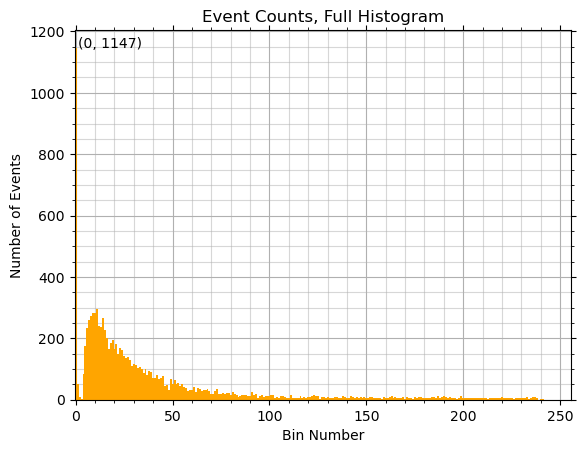

In [51]:
plt.bar(np.array(range(256)), counts, width = 1, color = "orange")
plt.grid()
plt.grid(which = 'minor', alpha = 0.5)
plt.text(1, counts[0], f"(0, {counts[0]})")
plt.title("Event Counts, Full Histogram")
plt.xlabel("Bin Number")
plt.ylabel("Number of Events")
plt.savefig("full_hist.png")

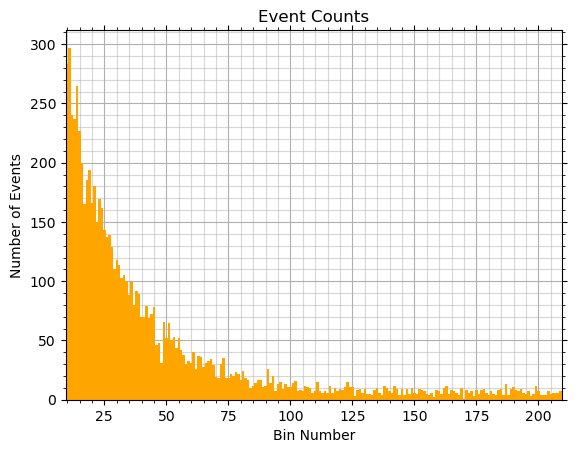

In [52]:
plt.bar(X + 10, ctrunc, width = 1, color = 'orange')
plt.grid()
plt.grid(which = 'minor', alpha = 0.5)
plt.ylim(bottom = 0)
plt.title("Event Counts")
plt.xlabel("Bin Number")
plt.ylabel("Number of Events")
plt.savefig("trunc_hist.png")

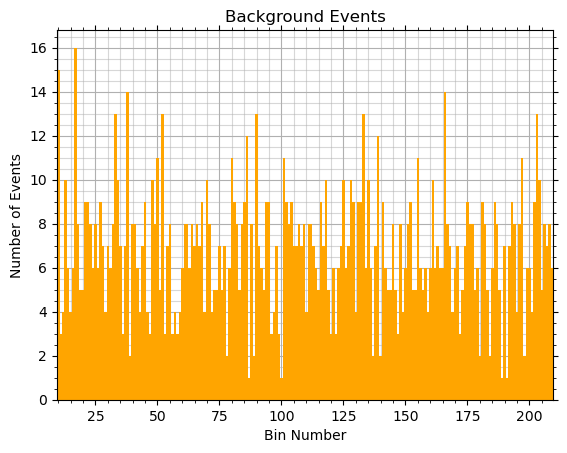

In [53]:
plt.bar(X + 10, btrunc, width = 1, color = 'orange')
plt.grid()
plt.grid(which = 'minor', alpha = 0.5)
plt.ylim(bottom = 0)
plt.title("Background Events")
plt.xlabel("Bin Number")
plt.ylabel("Number of Events")
plt.savefig("background.png")

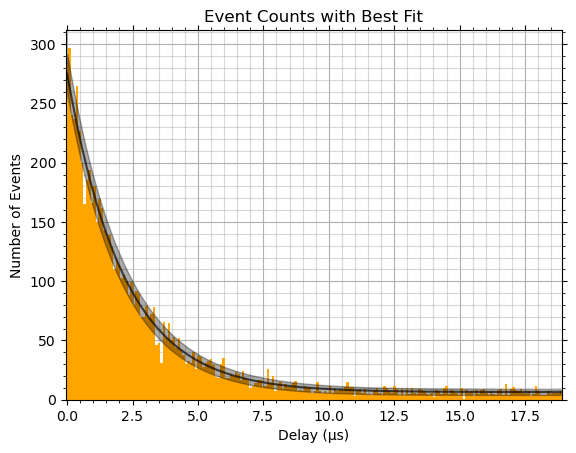

In [54]:
t = X * m / 1000
y = F2(X, *P2s)
plt.bar(t, ctrunc, width = m / 1000, color = 'orange')
plt.plot(t, y, c = 'black', alpha = 0.66)
plt.fill_between(t, y - sigma, y + sigma, color = 'black', alpha = 0.33)
plt.grid()
plt.grid(which = 'minor', alpha = 0.5)
plt.title("Event Counts with Best Fit")
plt.xlabel("Delay (µs)")
plt.ylabel("Number of Events")
plt.savefig("best_fit.png")

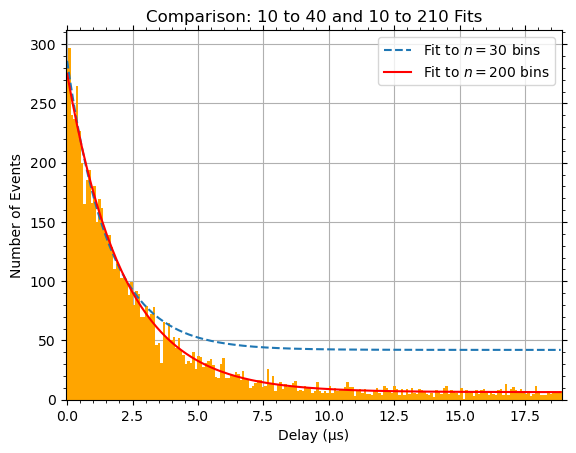

In [55]:
t = X * m / 1000
plt.bar(t, ctrunc, width = m / 1000, color = 'orange')
plt.plot(t, F2(X, *P2as), '--', label = "Fit to $n = 30$ bins")
plt.plot(t, F2(X, *P2s), 'r', label = "Fit to $n = 200$ bins")
plt.legend()
plt.grid()
plt.title("Comparison: 10 to 40 and 10 to 210 Fits")
plt.xlabel("Delay (µs)")
plt.ylabel("Number of Events")
plt.savefig("first_forty.png")

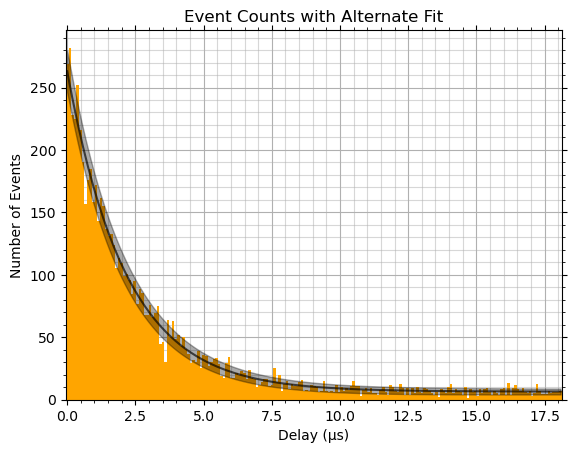

In [56]:
t = X_prime * m2 / 1000
y = F2(X_prime, *P2_prime)
plt.bar(t, c_prime, width = m2 / 950, color = 'orange')
plt.plot(t, y, c = 'black', alpha = 0.66)
plt.fill_between(t, y - sigma, y + sigma, color = 'black', alpha = 0.33)
plt.grid()
plt.grid(which = 'minor', alpha = 0.5)
plt.title("Event Counts with Alternate Fit")
plt.xlabel("Delay (µs)")
plt.ylabel("Number of Events")
plt.savefig("alt_fit.png")

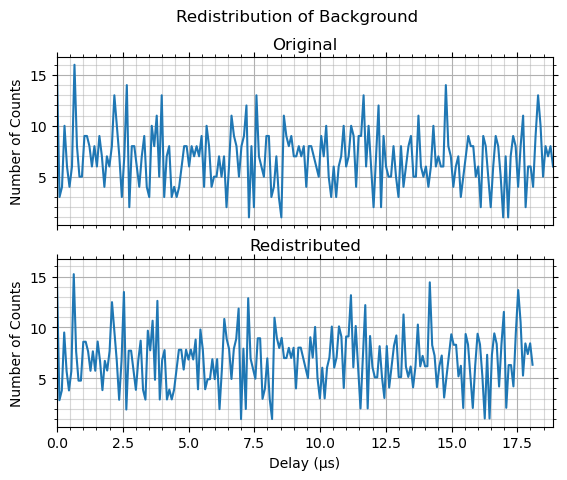

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = True)
ax1.plot(X * m / 1000, btrunc, label = "Original")
ax1.grid()
ax1.grid(which = 'minor', alpha = 0.5)
ax2.plot(X * m2 / 1000, b_prime, label = "Redistributed")
ax2.grid()
ax2.grid(which = 'minor', alpha = 0.5)
fig.suptitle("Redistribution of Background")
ax1.set_title("Original")
ax2.set_title("Redistributed")
ax1.set_ylabel("Number of Counts")
ax2.set_ylabel("Number of Counts")
ax2.set_xlabel("Delay (µs)")
plt.savefig("redis_background.png")

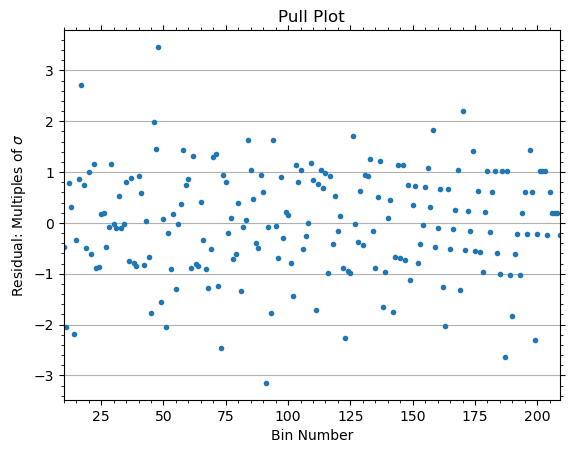

In [58]:
t = X * m / 1000
y = F2(X, *P2s)
residual = y - ctrunc
pull = residual / sigma

plt.plot(X+10, pull, '.')
plt.grid(axis = 'y')
plt.title("Pull Plot")
plt.ylabel("Residual: Multiples of $\\sigma$")
plt.xlabel("Bin Number")
plt.savefig("pull.png")

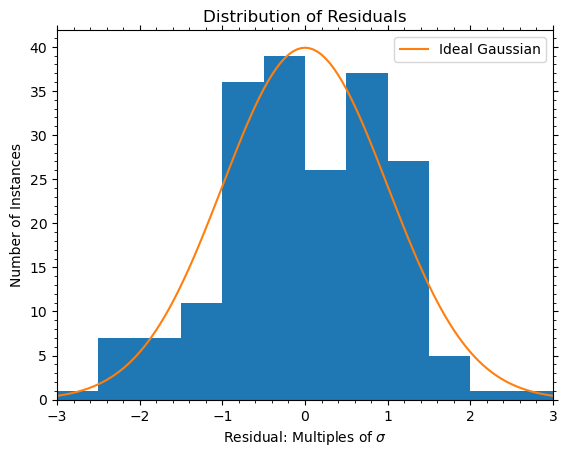

In [59]:
hbins = np.arange(-3, 3.1, 0.5)

# Normal distribution with mean of zero, deviation of 1
N = lambda x: np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
x_gauss = np.arange(-3, 3.01, 0.05)
y_gauss = N(x_gauss)

n_hist, _, _ = plt.hist(pull, hbins)
plt.plot(x_gauss, y_gauss * n * 0.5, label = "Ideal Gaussian")
plt.xlabel("Residual: Multiples of $\\sigma$")
plt.ylabel("Number of Instances")
plt.title("Distribution of Residuals")
plt.legend()
plt.savefig("distribution.png")

In [60]:
red_chisq = np.sum(pull ** 2) / (n - 3)
print(f"Reduced Chi-squared: {red_chisq:.2f}")

Reduced Chi-squared: 1.08
